In [1]:
from netCDF4 import Dataset
import glob as glob

In [2]:
# compute annual runoff by differencing the first and last accumulation surfaces

years = np.arange(2001,2009) # water years 2002-2013

for year in years:
    strtfl = '/Volumes/data/wrf/HW/CTRL/wrfout_d01_%s-10-01_00:00:00.nc_thinned_ave.nc'%(year-1)
    endfl = '/Volumes/data/wrf/HW/CTRL/wrfout_d01_%s-09-30_00:00:00.nc_thinned_ave.nc'%(year)
    
    start = Dataset(strtfl,'r')
    end = Dataset(endfl,'r')
    
    gw = np.array(end.variables['UDROFF']) - np.array(start.variables['UDROFF']) # mm/water year
    ro = np.array(end.variables['SFROFF']) - np.array(start.variables['SFROFF']) # mm/water year
    p = np.array(end.variables['RAINNC']) - np.array(start.variables['RAINNC']) # mm/water year
    
    np.savez_compressed('./data/HW_CTRL_runoff_wy%s.npz'%(year),ro)
    np.savez_compressed('./data/HW_CTRL_groundwater_wy%s.npz'%(year),gw)
    np.savez_compressed('./data/HW_CTRL_precipitation_wy%s.npz'%(year),p)
    
    print year
    

2001
2002
2003
2004
2005
2006
2007
2008


(0.0, 350.0, 0.0, 300.0)

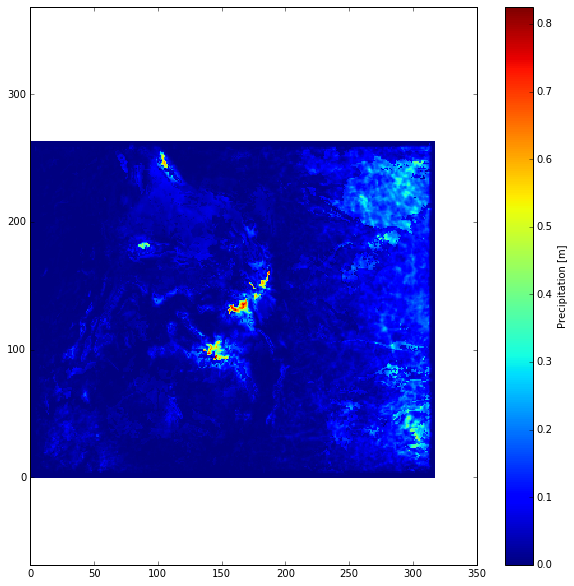

In [3]:
tmp = np.load('./data/HW_runoff_wy2001.npz')['arr_0'][0]/1000.
plt.figure(figsize=(10,10))
plt.pcolormesh(tmp)
plt.colorbar(label='Precipitation [m]')
plt.axis('equal')

In [4]:
## Processed Clipped Model Output

years = np.arange(2001,2009) # water years 2002-2013

for year in years:

    days = pd.date_range(start='10-01-'+str(year-1),end='09-30-'+str(year),freq='D')

    files = []
    for d in days: #loop through days and append to file list
        files.append('/Volumes/data/wrf/HW/CTRL/wrfout_d01_%s_00:00:00.nc_thinned_ave.nc'%(d.strftime('%Y-%m-%d')))

    n = len(files) # number of files
    d,h,w = np.array(Dataset(files[0],'r').variables['ACSNOM']).shape # get the shape of the array

    #preallocate numpy arrays
    snowmelt = np.empty((n,h,w)) # ACSNOM (accumulated)
    PET = np.empty((n,h,w)) # POTEVP (accumulated)
    LH = np.empty((1,h,w)) # LH
    P = np.empty((n,h,w)) # RAINNC (accumulated)

    #runoff = np.empty((1,h,w))
    #groundwater = runoff.copy()
    
    
    # preload the time slice before for accumulated variables
    #snow = np.array(Dataset('/Volumes/data/wrf/%s/wrf2d_d01_%s-09-30_thinned_crop.nc'%(year-1,year-1)).variables['UDROFF'])
    #pet = np.array(Dataset('/Volumes/data/wrf/%s/wrf2d_d01_%s-09-30_thinned_crop.nc'%(year-1,year-1)).variables['SFROFF'])

    ct = 0
    for fl in files:
        tmp = Dataset(fl,'r')        
        snowmelt[ct,:,:] = np.array(tmp.variables['ACSNOM']) *24. # kg/m2/hr >> kg/m2/day
        PET[ct,:,:] = np.array(tmp.variables['POTEVP']) # W/m2
        P[ct,:,:] = np.array(tmp.variables['RAINNC'])/1000. # m
        LH += np.array(tmp.variables['LH']) # W/m2
        ct += 1 # increment counter
        
    # compute averages 
    #print P.shape
    
    LH /= len(files) # w/m2
    
    sm1 = snowmelt[0:-1,:,:]
    sm2 = snowmelt[1:,:,:]
    
    sm = sm2-sm1
    sm /= 1000. #kg/m2 > m
    
    pet1 = PET[0:-1,:,:]
    pet2 = PET[1:,:,:]
    
    pet = pet2-pet1
    
    p1 = P[0:-1,:,:]
    p2 = P[1:,:,:]
    
    #print p1.shape
    #print p2.shape
    
    p = p2 - p1
    
    indexer = sm<=0.
    sm[indexer] = 0. # no negative snowmelt values
    p[indexer] = 0. # zero precip when snow is not melting
    
    wf = sm + p # add the two together
    
    pet = np.mean(pet,axis=0)
    sm = np.mean(sm, axis=0)
    wf = np.mean(wf, axis=0)
    
    #print sm.shape
    
    #print ct
    np.savez_compressed('./data/CTRL_snowmelt_wy%s.npz'%(year),sm) # m/day
    np.savez_compressed('./data/CTRL_LH_wy%s.npz'%(year),LH)
    np.savez_compressed('./data/CTRL_PET_wy%s.npz'%(year),pet)
    np.savez_compressed('./data/CTRL_water_flux_wy%s.npz'%(year),wf) # m/day
    
    print 'Processed Water Year %s'%(year)

Processed Water Year 2001
Processed Water Year 2002
Processed Water Year 2003
Processed Water Year 2004
Processed Water Year 2005
Processed Water Year 2006
Processed Water Year 2007
Processed Water Year 2008


In [6]:
# Load the cell indexer
indexer = np.load('./data/HW_index.npy')

In [7]:
indexer.shape

(263, 317)

In [8]:
# define a function to convert the numpy data files to a giant data frame
def load_data(wflux,surf,base,snowmelt,precip,year,idx):
    '''
    wflux = water flux (rain + snowmelt)
    surf = surface runoff
    base = baseflow
    year = water year
    idx = indexer
    
    Function to reshape input data and append it onto the larger data frame
    
    '''
    
    m,p = np.shape(wflux)
    wflux = np.reshape(wflux,(m*p))
    surf = np.reshape(surf,(m*p))
    base = np.reshape(base,(m*p))
    snowmelt = np.reshape(snowmelt,(m*p))
    precip = np.reshape(precip,(m*p))
    year = np.repeat(year,m*p)
    idx = np.reshape(idx,(m*p))
    
    # return a data frame of the input data to be appended onto the mother data frame
    return pd.DataFrame({'idx':idx,'wyear':year,'wflux':wflux,'runoff':surf,'baseflow':base,
                         'snowmelt':snowmelt,'precip':precip})
    
    

In [9]:
tmp = load_data(wflux,surf,base,snowmelt,precip,year,indexer)

In [10]:
# numpy files to data frame
wateryears = np.arange(2001,2009) 
    
df = pd.DataFrame()
for year in wateryears:
    wflux = np.load('./data/water_flux_wy%s.npz'%year)['arr_0']
    surf = np.load('./data/HW_runoff_wy%s.npz'%year)['arr_0']
    base = np.load('./data/HW_groundwater_wy%s.npz'%year)['arr_0']
    snowmelt = np.load('./data/snowmelt_wy%s.npz'%year)['arr_0']
    precip = np.load('./data/HW_precipitation_wy%s.npz'%year)['arr_0']
    df = df.append(load_data(wflux,surf,base,snowmelt,precip,year,indexer))
    print year

2001
2002
2003
2004
2005
2006
2007
2008


In [11]:
df.to_pickle('./data/HW_wrf_data.df') # save the data frame